## SONNMF on synthentic data

This notebook contains two experiments presented in the article:
1. SONNMF is evaluated against basic/vanilla NMF.
2. The runtime of 3 different BCD algorithms are compared for the W-subproblem: Proximal Averaging (our chosen method), ADMM, Nesterov's smoothing.

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

In [2]:
import time
import json  
import numpy as np
from sklearn.decomposition import NMF
from sonnmf.core.main import sonnmf
from sonnmf.legacy.main import sonnmf as sonnmf_legacy
import matplotlib.pyplot as plt
import h5py  # For HDF5 file handling

In [3]:
def save_h5(filepath, **kwargs):
    """
    Save data to an HDF5 file.

    Parameters:
        filepath (str): Path to save the file.
        kwargs: Data to save.
    """
    with h5py.File(filepath, 'w') as h5file:
        for key, value in kwargs.items():
            h5file.create_dataset(key, data=value)

def load_h5(filepath):
    """
    Load data from an HDF5 file.

    Parameters:
        filepath (str): Path to the file.

    Returns:
        dict: Loaded data.
    """
    data = {}
    with h5py.File(filepath, 'r') as h5file:
        for key in h5file.keys():
            data[key] = h5file[key][:]
    return data

def initialize_matrices(filepath, m, n, rank):
    """
    Initialize W and H, either by loading from a file or generating randomly.

    Parameters:
        filepath (str): Path to the file to load/save the factors.
        m (int): Number of rows in the data matrix.
        n (int): Number of columns in the data matrix.
        rank (int): Rank for the factorization.

    Returns:
        tuple: Initialized W and H factors.
    """
    if os.path.exists(filepath):
        data = load_h5(filepath)
        W_init = data['W_init']
        H_init = data['H_init']
    else:
        W_init = np.random.rand(m, rank)
        H_init = np.random.rand(rank, n)
        save_h5(filepath, W_init=W_init, H_init=H_init)
    return W_init, H_init

def plot_3d(X, W_true, W_estimated, ax=None, legend=None):
    """
    Plot data and factor matrices in 3D.

    Parameters:
        X (np.ndarray): Data matrix.
        W_true (np.ndarray): True W matrix.
        W_estimated (np.ndarray): Estimated W matrix.
        ax (matplotlib.axes._subplots.Axes3DSubplot, optional): Axes to plot on.
        legend (list, optional): Legend labels.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
    ax.scatter(W_true[0, :], W_true[1, :], W_true[2, :], c='red', marker='o', s=144)
    ax.scatter(W_estimated[0, :], W_estimated[1, :], W_estimated[2, :], c='black', marker='x', s=144)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    if legend:
        ax.legend(legend)
    ax.grid(True)

In [4]:
# Filepaths for data, saved models and images
data_dir = '../datasets/'
os.makedirs(data_dir, exist_ok=True)

saved_model_dir = '../saved_models/synthetic/'
os.makedirs(saved_model_dir, exist_ok=True)

images_dir = '../images/'
os.makedirs(images_dir, exist_ok=True)

### Creating the synthetic data

In [5]:
def sample_dirichlet(alpha, num_samples):
    """
    Generate samples from a Dirichlet distribution.

    Parameters:
        alpha (list): Parameters of the Dirichlet distribution.
        num_samples (int): Number of samples to generate.

    Returns:
        np.ndarray: Generated samples.
    """
    k = len(alpha)
    theta = np.zeros((num_samples, k))
    for i in range(k):
        theta[:, i] = np.random.gamma(alpha[i], 1, num_samples)
    theta /= theta.sum(axis=1, keepdims=True)
    return theta

def create_synthetic_data():
    """
    Create synthetic data for experiments.

    Returns:
        tuple: Synthetic data matrix, true W, and true H.
    """
    W_true = np.array([[1, 0, 0, 1], 
                       [1, 0, 1, 0], 
                       [0, 1, 1, 0], 
                       [0, 1, 0, 1]])
    r = 4
    num_samples = 500
    purity = 0.8
    alpha = 0.05 * np.ones(r)
    H_true = sample_dirichlet(alpha, num_samples).T

    for j in range(num_samples):
        while np.max(H_true[:, j]) > purity:
            H_true[:, j] = sample_dirichlet(alpha, 1).T.flatten()

    noise = 0.01
    X_true = W_true @ H_true
    X = np.maximum(0, X_true + noise * np.random.randn(*X_true.shape))
    return X, W_true, H_true

In [6]:
data_filepath = '../datasets/synthetic_data.h5'
if os.path.exists(data_filepath):
    data = load_h5(data_filepath)
    M = data['M']
    W_true = data['W_true']
    H_true = data['H_true']
else:
    M, W_true, H_true = create_synthetic_data()
    save_h5(data_filepath, M=M, W_true=W_true, H_true=H_true)
    
m, n = M.shape

### Experiment 1: Evaluating SONNMF against vanilla NMF

#### Running both algorithms with rank 4

In [7]:
rank = 4
max_iters = 1000
lambda_reg = 1e-6
gamma_reg = 10

In [8]:
# Initialize W and H
ini_filepath = os.path.join(saved_model_dir, f'rank{rank}_init.h5')
W_init, H_init = initialize_matrices(ini_filepath, m, n, rank)


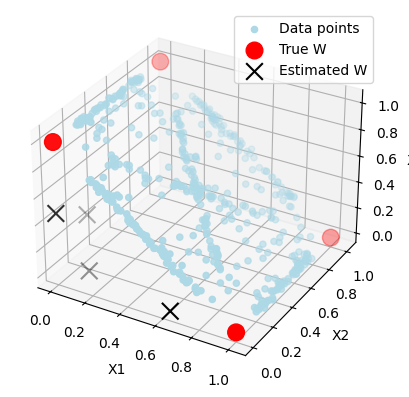

In [9]:
# vanilla NMF
vanilla_filepath = os.path.join(saved_model_dir, f'vanilla_rank{rank}_iters{max_iters}.h5')
if os.path.exists(vanilla_filepath):
    data = load_h5(vanilla_filepath)
    W_vanilla = data['W']
    H_vanilla = data['H']
else:
    model = NMF(n_components=rank, init='custom', random_state=42, max_iter=max_iters)
    W_vanilla = model.fit_transform(X=M, W=W_init.copy(), H=H_init.copy())
    H_vanilla = model.components_
    save_h5(vanilla_filepath, W=W_vanilla, H=H_vanilla)

plot_3d(M, W_true, W_vanilla, legend=['Data points', 'True W', 'Estimated W'])

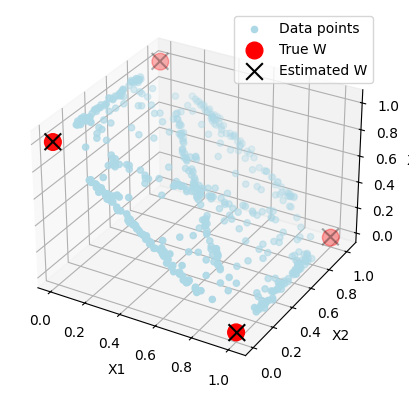

In [10]:
# SONNMF
sonnmf_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_gamma{gamma_reg}_iters{max_iters}.h5')
if os.path.exists(sonnmf_filepath):
    data = load_h5(sonnmf_filepath)
    W_sonnmf = data['W']
    H_sonnmf = data['H']
else:
    W_sonnmf, H_sonnmf, fscores, gscores, hscores, total_scores = sonnmf(M, W_init.copy(), H_init.copy(), lam=lambda_reg, gamma=gamma_reg, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    save_h5(sonnmf_filepath, W=W_sonnmf, H=H_sonnmf, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

plot_3d(M, W_true, W_sonnmf, legend=['Data points', 'True W', 'Estimated W'])


#### Running both algorithms with rank 8

In [11]:
rank = 8
max_iters = 1000
lambda_reg = 1e-6
gamma_reg = 1.5

In [12]:
# Initialize W and H
ini_filepath = os.path.join(saved_model_dir, f'rank{rank}_init.h5')
W_init, H_init = initialize_matrices(ini_filepath, m, n, rank)

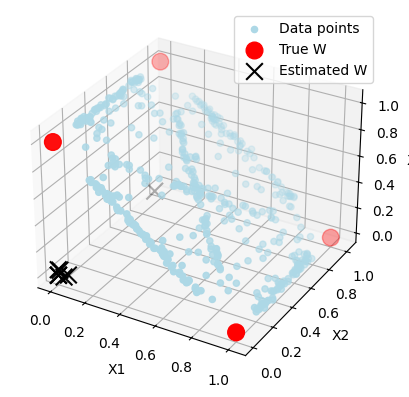

In [13]:
# vanilla NMF
vanilla_filepath = os.path.join(saved_model_dir, f'vanilla_rank{rank}_iters{max_iters}.h5')
if os.path.exists(vanilla_filepath):
    data = load_h5(vanilla_filepath)
    W_vanilla = data['W']
    H_vanilla = data['H']
else:
    model = NMF(n_components=rank, init='custom', random_state=42, max_iter=max_iters)
    W_vanilla = model.fit_transform(X=M, W=W_init.copy(), H=H_init.copy())
    H_vanilla = model.components_
    save_h5(vanilla_filepath, W=W_vanilla, H=H_vanilla)

plot_3d(M, W_true, W_vanilla, legend=['Data points', 'True W', 'Estimated W'])


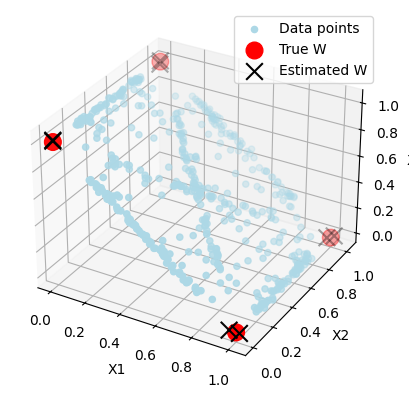

In [14]:
# SONNMF
sonnmf_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_gamma{gamma_reg}_iters{max_iters}.h5')
if os.path.exists(sonnmf_filepath):
    data = load_h5(sonnmf_filepath)
    W_sonnmf = data['W']
    H_sonnmf = data['H']
else:
    W_sonnmf, H_sonnmf, fscores, gscores, hscores, total_scores = sonnmf(M, W_init.copy(), H_init.copy(), lam=lambda_reg, gamma=gamma_reg, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    save_h5(sonnmf_filepath, W=W_sonnmf, H=H_sonnmf, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

plot_3d(M, W_true, W_sonnmf, legend=['Data points', 'True W', 'Estimated W'])


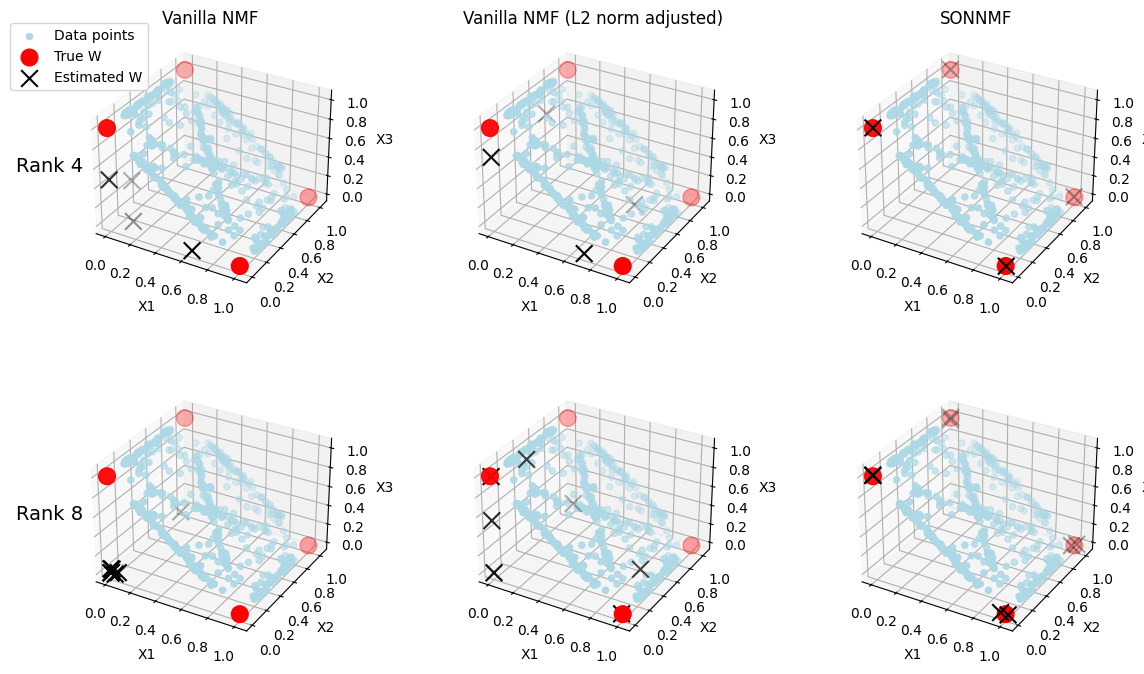

In [15]:
# creating plot for article (Figure 1)
row_labels = ['Rank 4', 'Rank 8']
col_labels = ['Vanilla NMF', 'Vanilla NMF (L2 norm adjusted)', 'SONNMF']

fig, axes = plt.subplots(2, len(col_labels), figsize=(14, 8), subplot_kw={'projection': '3d'})
fig.subplots_adjust(wspace=0.2, hspace=0.3)

# Parameters for each rank
ranks = [(4, 1e-6, 10), (8, 1e-6, 1.5)]

for row_idx, (rank, lambda_reg, gamma_reg) in enumerate(ranks):
    vanilla_filepath = os.path.join(saved_model_dir, f'vanilla_rank{rank}_iters{max_iters}.h5')
    sonnmf_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_gamma{gamma_reg}_iters{max_iters}.h5')

    # Load data from HDF5 files
    vW = load_h5(vanilla_filepath)['W']
    col_norm_vW = np.linalg.norm(vW, axis=0, ord=2, keepdims=True)
    vW_re = vW / (col_norm_vW + 1e-12)
    cW = load_h5(sonnmf_filepath)['W']

    # Plot each column
    for col_idx, curr_W in enumerate([vW, vW_re, cW]):
        ax = axes[row_idx, col_idx]
        plot_3d(M, W_true, curr_W, ax=ax)
        if row_idx == 0:
            ax.set_title(col_labels[col_idx], fontsize=12)

# Add row labels
for ax, rlabel in zip(axes[:, 0], row_labels):
    ax.text2D(-0.1, 0.5, rlabel, transform=ax.transAxes, ha='center', va='center', fontsize=14)

# Add legend and save the figure
# fig.legend(['Data points', 'True W', 'Estimated W'], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=10)
fig.legend(['Data points', 'True W', 'Estimated W'], bbox_to_anchor=(0.2, 0.9, 0, 0))
plt.savefig(os.path.join(images_dir, 'synthetic_vanilla_vs_sonnmf.pdf'), bbox_inches='tight')
plt.show()

### Experiment 1: Evaluating different solvers for the W-subproblem

In [16]:
runtime_results = []

In [17]:
# Proximal Averaging
proxavg_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_gamma{gamma_reg}_iters{max_iters}_proxavg.h5')
if os.path.exists(proxavg_filepath):
    data = load_h5(proxavg_filepath)
    W_proxavg = data['W']
    H_proxavg = data['H']
else:
    start_time = time.time()
    W_proxavg, H_proxavg, fscores, gscores, hscores, total_scores = sonnmf(M, W_init.copy(), H_init.copy(), lam=lambda_reg, gamma=gamma_reg, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    time_taken = time.time() - start_time
    save_h5(proxavg_filepath, W=W_proxavg, H=H_proxavg, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

    runtime_results.append({
        'Dataset': 'synthetic_r8',
        'Method': 'proxavg',
        'Time Taken (s)': time_taken,
        'Save Filepath': proxavg_filepath
    })

In [18]:
# ADMM
admm_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_iters{max_iters}_admm.h5')
if os.path.exists(admm_filepath):
    data = load_h5(admm_filepath)
    W_admm = data['W']
    H_admm = data['H']
else:
    start_time = time.time()
    W_admm, H_admm, fscores, gscores, total_scores = sonnmf_legacy(M, W_init.copy(), H_init.copy(), lam=lambda_reg, w_update_method='admm', itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    time_taken = time.time() - start_time
    save_h5(admm_filepath, W=W_admm, H=H_admm, fscores=fscores, gscores=gscores, total_scores=total_scores)

    runtime_results.append({
        'Dataset': 'synthetic_r8',
        'Method': 'admm',
        'Time Taken (s)': time_taken,
        'Save Filepath': admm_filepath
    })

In [19]:
# Nesterov's Smoothing Solver
nesterov_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_iters{max_iters}_nesterov.h5')
if os.path.exists(nesterov_filepath):
    data = load_h5(nesterov_filepath)
    W_nesterov = data['W']
    H_nesterov = data['H']
else:
    start_time = time.time()
    W_nesterov, H_nesterov, fscores, gscores, total_scores = sonnmf_legacy(M, W_init.copy(), H_init.copy(), lam=lambda_reg, w_update_method='nesterov_smoothing', itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    time_taken = time.time() - start_time
    save_h5(nesterov_filepath, W=W_nesterov, H=H_nesterov, fscores=fscores, gscores=gscores, total_scores=total_scores)

    runtime_results.append({
        'Dataset': 'synthetic_r8',
        'Method': 'nesterov_smoothing',
        'Time Taken (s)': time_taken,
        'Save Filepath': nesterov_filepath
    })

In [20]:
json_filepath = os.path.join(saved_model_dir, 'runtime_results.json')
if os.path.exists(json_filepath):
    with open(json_filepath, 'r') as json_file:
        runtime_results = json.load(json_file)
    for result in runtime_results:
        print(result)
else:
    with open(json_filepath, 'w') as json_file:
        json.dump(runtime_results, json_file, indent=4)

{'Dataset': 'sythetic_r8', 'Method': 'proxavg', 'Time Taken (s)': 22.29576086997986, 'Save Filepath': '../saved_models/synthetic/rank8_lambda1e-06_gamma1.5_iters1000_proxavg.h5'}
{'Dataset': 'sythetic_r8', 'Method': 'admm', 'Time Taken (s)': 1094.1843938827515, 'Save Filepath': '../saved_models/synthetic/rank8_lambda1e-06_iters1000_admm.h5'}
{'Dataset': 'sythetic_r8', 'Method': 'nesterov_smoothing', 'Time Taken (s)': 497.1603350639343, 'Save Filepath': '../saved_models/synthetic/rank8_lambda1e-06_iters1000_nesterov.h5'}


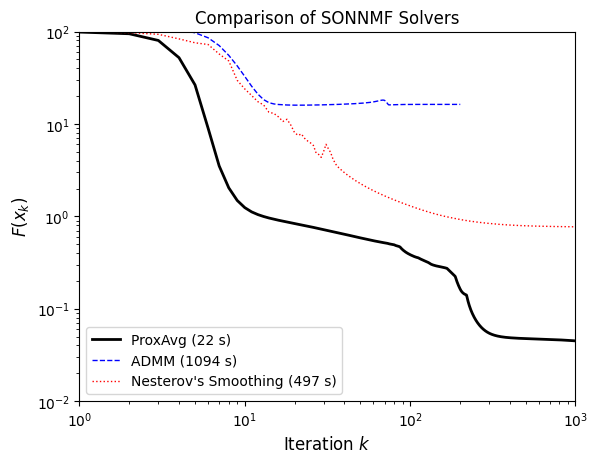

In [21]:
# Plot Comparison of Solvers
data = load_h5(proxavg_filepath)
fscores, gscores = data['fscores'], data['gscores']
plt.plot(fscores + lambda_reg * gscores, 'k-', linewidth=2, label='ProxAvg (22 s)')

data = load_h5(admm_filepath)
total_scores = data['total_scores']
plt.plot(total_scores, 'b--', linewidth=1, label='ADMM (1094 s)')

data = load_h5(nesterov_filepath)
total_scores = data['total_scores']
plt.plot(total_scores, 'r:', linewidth=1, label="Nesterov's Smoothing (497 s)")

plt.xlim((1, max_iters))
plt.ylim((1e-2, 1e2))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration $k$', fontsize=12)
plt.ylabel('$F(x_k)$', fontsize=12)
plt.title('Comparison of SONNMF Solvers')
plt.savefig(os.path.join(images_dir, 'synthetic_r8_solvers_comparison.pdf'), bbox_inches='tight')
plt.show()